# XGBoost

* [Preliminary Run](#Preliminary-Run)
* [GridSearch](#GridSearch)
* [Balance Testing](#Balance-Testing)
* [Model Export](#Model-Export)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.facecolor']='w'

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import pickle

In [5]:
teledf = pd.read_csv('data/teledf_final.csv', index_col=0)
teledf.head()

,Total day minutes,Area code_408,Number vmail messages,Churn,Total eve charge,Area code_415,Area code_510,Total day calls,Total intl calls,Total eve minutes,Total intl charge,International plan,Customer service calls,Voice mail plan,Total intl minutes,Total day charge
0,265.1,0.0,25.0,0.0,16.78,1.0,0.0,110.0,3.0,197.4,2.70,0.0,1.0,1.0,10.0,45.07
1,161.6,0.0,26.0,0.0,16.62,1.0,0.0,123.0,3.0,195.5,3.70,0.0,1.0,1.0,13.7,27.47
2,243.4,0.0,0.0,0.0,10.30,1.0,0.0,114.0,5.0,121.2,3.29,0.0,0.0,0.0,12.2,41.38
3,299.4,1.0,0.0,0.0,5.26,0.0,0.0,71.0,7.0,61.9,1.78,1.0,2.0,0.0,6.6,50.90
4,166.7,0.0,0.0,0.0,12.61,1.0,0.0,113.0,3.0,148.3,2.73,1.0,3.0,0.0,10.1,28.34


In [6]:
X = teledf.drop(columns='Churn')
y = teledf['Churn']

X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, test_size=0.2, random_state=42)

# Preliminary Run

In [7]:
# fit model

xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [8]:
# metrics

xgb_model.score(X_train,y_train), xgb_model.score(X_val, y_val)

(0.9671669793621013, 0.9456928838951311)

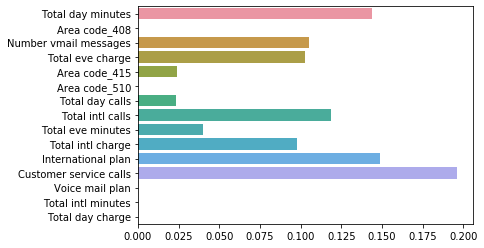

In [9]:
sns.barplot(y=X.columns,x=xgb_model.feature_importances_)

Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

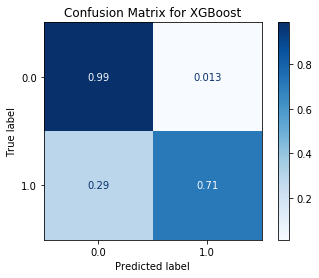

In [10]:
plot_confusion_matrix(xgb_model, 
                      X_val,
                      y_val,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for XGBoost')

Results of XGBoost are the best of the tested models (marginally better than normal gradient boosting).
Optimization will be conducted to finalize the XGBoost model, with the aim of decreasing false negative classifications (recall).

# GridSearch

In [13]:
grid_xgb=XGBClassifier(early_stopping_rounds=10, booster='gbtree', random_state=42)

params={
    'max_depth':[3,4,5,6,7],
    'learning_rate':[0.001,0.01,0.1,0.3],
    'min_child_weight':[1,3,5],
    'gamma':[0,0.1,0.3],
    'colsample_bytree':[0.3,0.5,0.8]
}

In [14]:
gridsearch_xgb = GridSearchCV(grid_xgb,
                             params,
                             scoring='recall',
                             cv=5,
                             n_jobs=-1)

In [15]:
gridsearch_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     early_stopping_rounds=10, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.8],
                         'gamma': [0, 0.1, 0.3],
    

In [16]:
gridsearch_xgb.best_score_

0.7516129032258064

In [17]:
gridsearch_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1}

# Balance Testing

In [11]:
# run model without sampling

xgb_final = XGBClassifier(colsample_bytree=0.8,
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          min_child_weight=1,
                          early_stopping_rounds=10, 
                          booster='gbtree', 
                          random_state=42, )

In [12]:
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, gamma=0.1, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [13]:
xgb_final.score(X_train,y_train), xgb_final.score(X_val, y_val)

(0.9807692307692307, 0.9531835205992509)

Text(0.5, 1.0, 'Confusion Matrix for Final XGBoost')

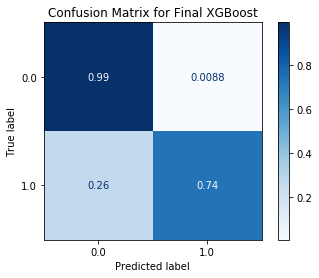

In [14]:
plot_confusion_matrix(xgb_final, 
                      X_val,
                      y_val,
                      cmap='Blues', 
                      normalize='true')
plt.title('Confusion Matrix for Final XGBoost')

random_over_sampler.RandomOverSampler


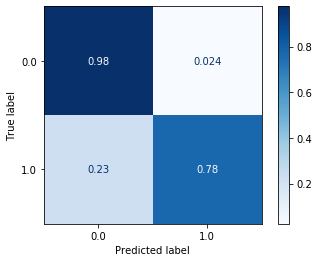

smote.SMOTE


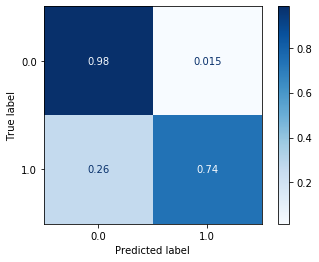

adasyn.ADASYN


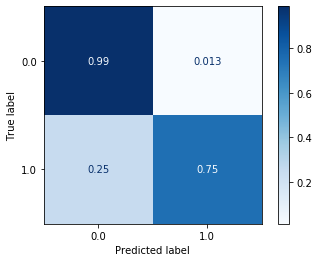

In [12]:
# compare to model with sampling

for i in [RandomOverSampler, SMOTE, ADASYN]:
    balancer = i(random_state=42)
    X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)
    bal_xgb_model = xgb_final
    bal_xgb_model.fit(X_train_bal, y_train_bal)
    y_train_bal_pred = bal_xgb_model.predict(X_train_bal)
    y_test_bal_pred = bal_xgb_model.predict(X_test)
    print(f'{str(i)[32:-2]}')
    plot_confusion_matrix(bal_xgb_model, 
                      X_val,
                      y_val,
                      cmap='Blues', 
                      normalize='true')
    plt.show()

Best confusion matrix result from random oversampling XGBoost.
* recall score inferior to final Decision Tree result
* precision score is an improvement
* choosing this model since basis of the assignment is ensemble/boosting methods

## Model Export

Finalize and export model as pickle file.

In [17]:
# finalize fit

xgb_final = XGBClassifier(colsample_bytree=0.8,
                          gamma=0.1,
                          learning_rate=0.1,
                          max_depth=6,
                          min_child_weight=1,
                          early_stopping_rounds=10, 
                          booster='gbtree', 
                          random_state=42, )

balancer = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)

xgb_final.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, gamma=0.1, learning_rate=0.1,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [18]:
pickle.dump(xgb_final, open('final_model', 'wb'))